In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch


In [4]:

train_data =datasets.MNIST(root='data',train=True, download = True,transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train= False, download = True, transform=transforms.ToTensor())

X_train, y_train = train_data.data, train_data.targets
X_test, y_test = test_data.data, test_data.targets

# Reshaping the data matrices
X_train = X_train.reshape(X_train.shape[0], 784).numpy()
X_test = X_test.reshape(X_test.shape[0], 784).numpy()

# Normalizing the pixel intensities
X_train = X_train/255.0
X_test = X_test/255.0
print('x_train shape', X_train.shape)
print('x test shape', X_test.shape)


100%|██████████| 9912422/9912422 [00:00<00:00, 137134817.78it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 110930122.55it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46502766.25it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19990061.67it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



x_train shape (60000, 784)
x test shape (10000, 784)


In [5]:
# Number of training examples
M = X_train.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = 784

# Number of classes
num_classes = len(np.unique(y_train))

# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1

print("Number of images in the training set =", M)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)
print('x train shape', X_train.shape)


Number of images in the training set = 60000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784
x train shape (60000, 784)


In [6]:
X_train = X_train.T
# X_val = X_val.T
X_test = X_test.T
# X = X.T

print(X_train.shape)
print(X_test.shape)
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)

(784, 60000)
(784, 10000)
(10, 60000)
(10, 10000)


In [7]:
def sigmoid(x,derivative= False):
  if derivative:
    return (np.exp(-x))/((np.exp(-x)+1)**2)
  return 1. / (1.+np.exp(-x))

def Relu(x,derivative=False):
  if derivative:
    return 1*(x>0)
  return np.maximum(0,x)

def tanh(x,derivative=False):
  if derivative:
    return (1 - (np.tanh(x)**2))
  return np.tanh(x)

def softmax(x,derivative=False):
  exps = np.exp(x - x.max())
  if derivative:
    return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
  return exps/np.sum(exps, axis=0)

def loss_function(Y, Y_hat, batch_size, loss, lamb, parameters):

    if loss == 'crossentropy':
         L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size
    elif loss == 'mse':
         L = (1/2) * np.sum((Y-Y_hat)**2)/batch_size

    #Add L2 regularisation
    acc = 0
    for i in range(1, len(parameters)//2 + 1):
        acc += np.sum(parameters["W"+str(i)]**2)

    L = L + (lamb/(2*batch_size))*acc

    return L

In [8]:
def initialize_parameters(layer_dims, init_mode="xavier"):
    '''Function to initialise weights, biases and velocities/previous updates of the NN
    Parameters
    ----------
    layer_dims: list
        list of number of neurons per layer specifying layer dimensions in the format [#input_features,#hiddenunits...#hiddenunits,#outputclasses]
    init_mode: string
        initialisation mode, default-"xavier"
    Returns
    -------
    params: dict
        contains weights and biases. eg params[W1] is weight for layer 1

    previous updates: dict
        previous updates initialisation. This is used for different perposes for different optimisers.
    '''
    np.random.seed(42)
    params = {}
    previous_updates = {}

    for i in range(1, len(layer_dims)):
        if init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
        elif init_mode == 'glorot':
            params["W"+str(i)]= np.random.uniform(low=-np.sqrt(6/layer_dims[i-1]), high =np.sqrt(6/layer_dims[i-1]), size =(layer_dims[i], layer_dims[i-1]))



        params["b"+str(i)] = np.zeros((layer_dims[i], 1))

        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    return params,previous_updates

In [9]:
def forward_prop(X, params, activation_f):
    '''Function to forward propagate a minibatch of data once through the NN
    Parameters
    ----------
    X: numpy array
        data in (features,batch_size) format
    params: dict
        W and b of the NN
    activation_f: string
        activation function to be used except the output layer
    Returns
    -------
    output: numpy array
        contains the output probabilities for each class and each data sample after 1 pass
    A: numpy array
        contains all post-activations
    Z: numpy array
        contsins all pre-activations
    '''
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations

    A[0] = X

    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]

        Z[l] = np.matmul(W,A[l-1]) + b

        if l == L-1:
            A[l] = softmax(Z[l], derivative = False) # activation function for output layer
        else:
            if activation_f == 'sigmoid':
                A[l] = sigmoid(Z[l], derivative = False)
            elif activation_f == 'relu':
                A[l] = Relu(Z[l], derivative = False)
            elif activation_f == 'tanh':
                A[l] = tanh(Z[l], derivative = False)

    output = A[L-1]

    return output,A,Z

In [10]:
def backprop(y_hat, y,A, Z, params, activation_f, batch_size, loss, lamb):
    '''Function to calculate gradients for a minibatch of data once through the NN through backpropagation
    Parameters
    ----------
    y_hat: numpy array
        output from forward propagation/ class probabilities
    y: numpy array
        actual class labels
    A: numpy array
        post-activations
    Z: numpy array
        pre-activations
    params: dict
        contains W and b on the NN
    activation_f: string
        activation function to be used except the output layer
    batch_size: int
        mini-batch-size
    loss: string
        loss function (MSE/Categorical crossentropy)
    lamb: float
        L2 regularisation lambda
    Returns
    -------
    gradients: dict
        gradients wrt weights and biases
    '''
    L = len(params)//2 #no. of layers
    gradients = {}

    #process last layer which has softmax
    if loss == 'crossentropy':
        gradients["dZ"+str(L)] = A[L]-y
    elif loss == 'mse':
        gradients["dZ"+str(L)] = (A[L]-y) * softmax(Z[L], derivative = True)

    #process other layers
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (np.dot(gradients["dZ" + str(l)], A[l-1].T) + lamb*params["W"+str(l)]) / batch_size
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / batch_size

        if l>1:
            if activation_f == 'sigmoid':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * sigmoid(Z[l-1], derivative = True)
            elif activation_f == 'relu':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * Relu(Z[l-1], derivative = True)
            elif activation_f == 'tanh':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * tanh(Z[l-1], derivative = True)

    return gradients

In [11]:
def update_gradients(parameters,grads,learning_rate):
    ''' Update W and b of the NN according to sgd updates
    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN
    grads: dict
        contains gradients wrt W and b returned by backpropagation
    learning_rate: float
        learning rate
    Returns
    -------
    parameters: dict
        updated NN parameters
    '''
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters



In [12]:
def predict(X_test, params, activation_f):
    '''
    forward propagate once and calculate labels
    '''
    output, _, _ = forward_prop(X_test, params, activation_f)
    predictions = np.argmax(output, axis=0)
    return predictions

def evaluate(X_train, y_train, X_test, y_test, params, activation_f):
    '''
    print train,test accuracies and the classification report using sklearn

    '''
    train_predictions = predict(X_train, params, activation_f)
    test_predictions = predict(X_test, params, activation_f)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100, 3)))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100, 3)))

    print("Classification report for the test set:\n")
    print(classification_report(y_test, test_predictions))

    return train_predictions, test_predictions

In [13]:
def best_fit(X_train, y_train_one_hot, learning_rate = 0.001, activation_f = 'sigmoid', init_mode = 'xavier',
                optimizer = 'sgd', batch_size = 512, loss = 'crossentropy', epochs = 20, L2_lamb = 0,
                num_neurons = 64, num_hidden = 3):
    """This function is used to train the neural network on the full dataset given the best set of hyperparameter values
    X_train: numpy array
        train dataset
    y_train_one_hot: numpy array
        train labels with one-hot encoding
    learning_rate: float
    activation_f: string
        activation functions for all the layers except the last layer which is softmax
    init_mode: string
        initialization mode
    optimizer: string
        optimization routine
    bach_size: int
        minibatch size
    loss: string
        loss function
    epochs: int
        number of epochs to be used
    L2_lamb: float
        lambda for L2 regularisation of weights
    num_neurons: int
        number of neurons in every hidden layer
    num_hidden:
        number of hidden layers
    Returns
    -------
    parameters: dict
        weights and biases of the NN model
    epoch_cost: list
        training costs with every epoch
    """
    #Layer sizes
    hidden_layer = [500,250,100]
    # layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]
    layer_dims = [X_train.shape[0]] + hidden_layer + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices

    epoch_cost = []

    count = 1
    params_look_ahead = params.copy() # initialization for nestorov

    loss = 'crossentropy'

    while count<=epochs:
        count = count + 1 # increment the number of epochs

        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size

            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1


            output,A,Z = forward_prop(X_train[:,i:i+batch_size],params,activation_f)
            gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)


            params = update_gradients(params,gradients,learning_rate)


        # Mean loss for the full training set
        full_output, _, _ = forward_prop(X_train, params, activation_f)
        cost = loss_function(y_train_one_hot, full_output, M, loss, L2_lamb, params)

        if (count % 2 == 0):
            print("Epoch number: ", count, "\tTraining cost:", cost)

        epoch_cost.append(cost)


    # Plot the training cost curve
    plt.plot(list(range(len(epoch_cost))), epoch_cost, 'r', label="Training loss")
    plt.title("Training Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()


    return params, epoch_cost

# **BASELINE** **MODEL**


In [14]:
#Baseline model
#hyperparameters

LEARNING_RATE = 0.01
ACTIVATION = "sigmoid"
INITIALIZER = "glorot"
OPTIMIZER = "sgd"
BATCH_SIZE = 64
EPOCHS = 15
L2_lambda = 0
NUM_NEURONS = [500,250,100]
NUM_HIDDEN = 3
LOSS = 'crossentropy'

Epoch number:  2 	Training cost: 2.279371898895774
Epoch number:  4 	Training cost: 2.1996938221073066
Epoch number:  6 	Training cost: 1.8998806211223445
Epoch number:  8 	Training cost: 1.2422686081424312
Epoch number:  10 	Training cost: 0.866038213673311
Epoch number:  12 	Training cost: 0.6915021007398086
Epoch number:  14 	Training cost: 0.5844084954065603
Epoch number:  16 	Training cost: 0.5138769712128923


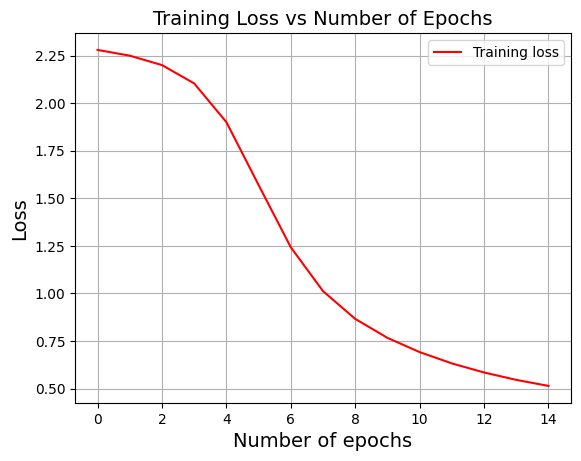

In [15]:
# One hot encoding for class labels (full training data)
y_one_hot = np.zeros((10, M ))
y_one_hot[y_train, np.array(list(range(M)))] = 1


learned_parameters, epoch_cost = best_fit(X_train, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

In [16]:
train_predictions, test_predictions = evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 85.607 %
Test accuracy = 85.9 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.91      0.97      0.94      1135
           2       0.91      0.82      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.81      0.84      0.82       982
           5       0.80      0.74      0.77       892
           6       0.89      0.91      0.90       958
           7       0.90      0.88      0.89      1028
           8       0.84      0.78      0.81       974
           9       0.77      0.80      0.78      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



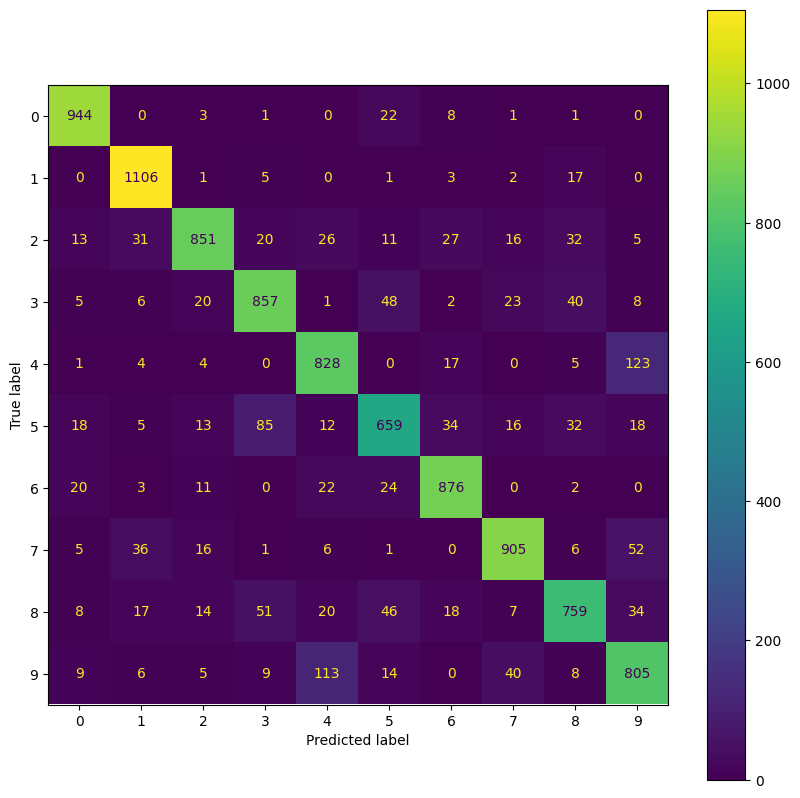

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names1 = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']
cm =confusion_matrix(y_test,test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names1)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()



# **Model 2 (with tanh activation function)**

Epoch number:  2 	Training cost: 0.34362214270980995
Epoch number:  4 	Training cost: 0.23903660029792215
Epoch number:  6 	Training cost: 0.19373109823244183
Epoch number:  8 	Training cost: 0.16389057760892597
Epoch number:  10 	Training cost: 0.1422357190459515
Epoch number:  12 	Training cost: 0.1256364742049177
Epoch number:  14 	Training cost: 0.11237600663759115
Epoch number:  16 	Training cost: 0.10143950925095846


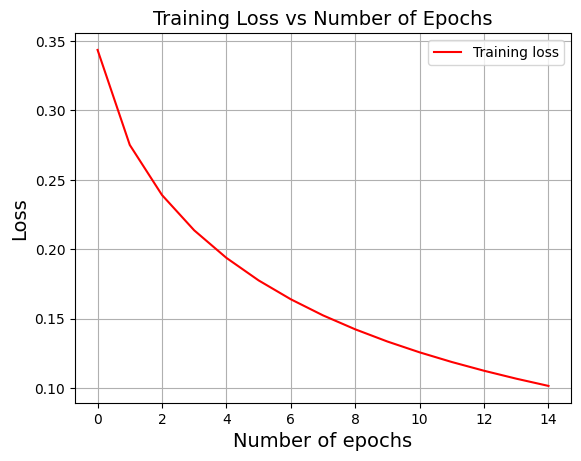

In [18]:
#MODEL 2 , with activation = tanh

LEARNING_RATE = 0.01
ACTIVATION = "tanh"
INITIALIZER = "glorot"
OPTIMIZER = "sgd"
BATCH_SIZE = 64
EPOCHS = 15
L2_lambda = 0
NUM_NEURONS = [500,250,100]
NUM_HIDDEN = 3
LOSS = 'crossentropy'

learned_parameters, epoch_cost = best_fit(X_train, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

In [19]:
train_predictions, test_predictions = evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 97.17 %
Test accuracy = 96.56 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.96       982
           5       0.96      0.97      0.96       892
           6       0.97      0.96      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



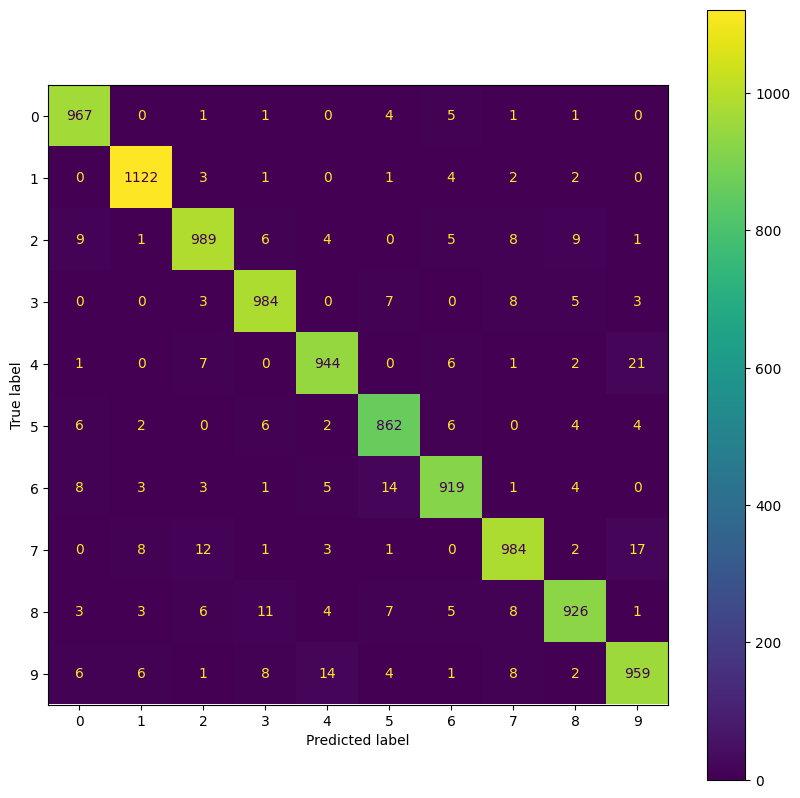

In [20]:
cm =confusion_matrix(y_test,test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names1)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## **Model 3 (with relu as activation function)**

Epoch number:  2 	Training cost: 0.3138070334617107
Epoch number:  4 	Training cost: 0.19460159295300472
Epoch number:  6 	Training cost: 0.1490862999753068
Epoch number:  8 	Training cost: 0.12115662936042472
Epoch number:  10 	Training cost: 0.1011100324044451
Epoch number:  12 	Training cost: 0.08580658945675741
Epoch number:  14 	Training cost: 0.07363604696602492
Epoch number:  16 	Training cost: 0.06372863398493188


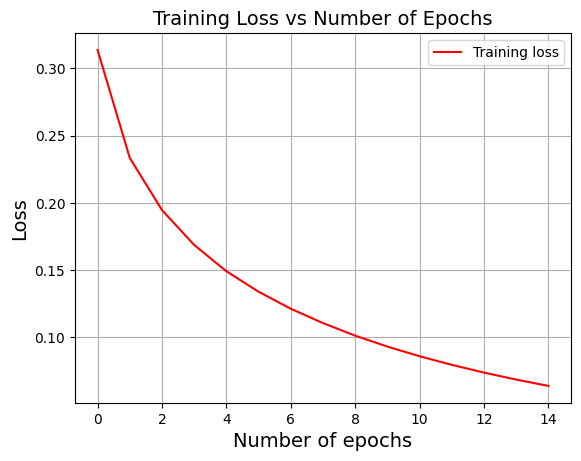

In [21]:
#MODEL 3 , with activation = relu

LEARNING_RATE = 0.01
ACTIVATION = "relu"
INITIALIZER = "glorot"
OPTIMIZER = "sgd"
BATCH_SIZE = 64
EPOCHS = 15
L2_lambda = 0
NUM_NEURONS = [500,250,100]
NUM_HIDDEN = 3
LOSS = 'crossentropy'

learned_parameters, epoch_cost = best_fit(X_train, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

In [22]:
train_predictions, test_predictions = evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 98.257 %
Test accuracy = 97.12 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.97      0.97       892
           6       0.98      0.96      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.98      0.95      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000




# Accuracies for different activation functions:
# Sigmoid: 85.9
# Tanh: 96.56
# ReLU: 97.12

## ReLU performs the best.


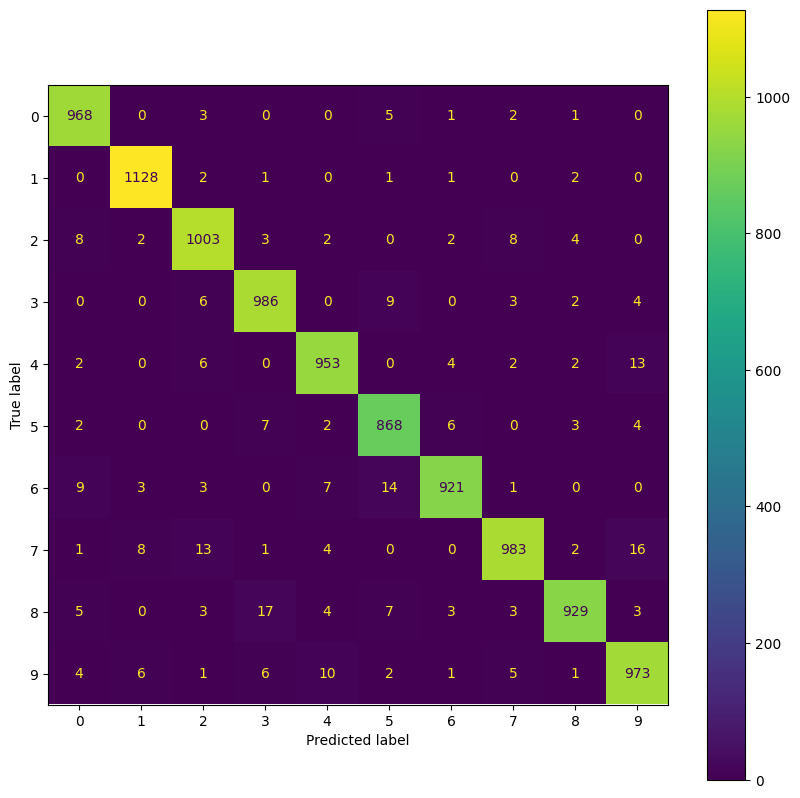

In [23]:
cm =confusion_matrix(y_test,test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names1)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## **Model 4 (changing the number of neurons and number of epochs)**

Epoch number:  2 	Training cost: 0.3138070334617107
Epoch number:  4 	Training cost: 0.19460159295300472
Epoch number:  6 	Training cost: 0.1490862999753068
Epoch number:  8 	Training cost: 0.12115662936042472
Epoch number:  10 	Training cost: 0.1011100324044451
Epoch number:  12 	Training cost: 0.08580658945675741
Epoch number:  14 	Training cost: 0.07363604696602492
Epoch number:  16 	Training cost: 0.06372863398493188
Epoch number:  18 	Training cost: 0.055600288311137114
Epoch number:  20 	Training cost: 0.048873703670190005
Epoch number:  22 	Training cost: 0.04306973898710047
Epoch number:  24 	Training cost: 0.03807527795750074
Epoch number:  26 	Training cost: 0.033816224681715336
Epoch number:  28 	Training cost: 0.030075541947845213
Epoch number:  30 	Training cost: 0.026755117963955084
Epoch number:  32 	Training cost: 0.023762561338966395
Epoch number:  34 	Training cost: 0.021046681744294478
Epoch number:  36 	Training cost: 0.018712493338564683
Epoch number:  38 	Training

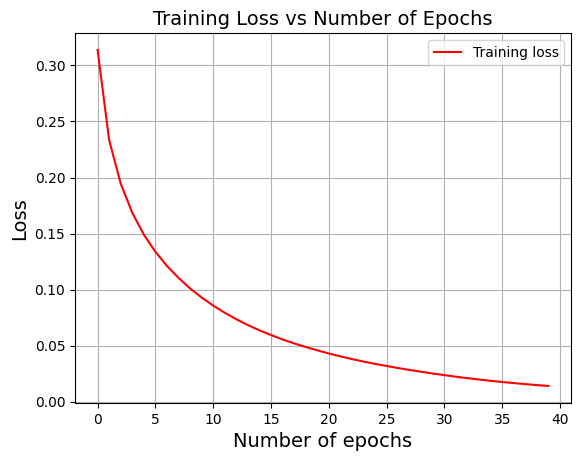

In [24]:
#model 4 , trial with neurons in the layers and epochsn  BEST MODEL
LEARNING_RATE = 0.01
ACTIVATION = "relu"
INITIALIZER = "glorot"
OPTIMIZER = "sgd"
BATCH_SIZE = 64
EPOCHS = 40 #
L2_lambda = 0
NUM_NEURONS = [512,250,128]  #
NUM_HIDDEN = 3
LOSS = 'crossentropy'

learned_parameters, epoch_cost = best_fit(X_train, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

In [25]:
train_predictions, test_predictions = evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 99.782 %
Test accuracy = 97.69 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.99      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



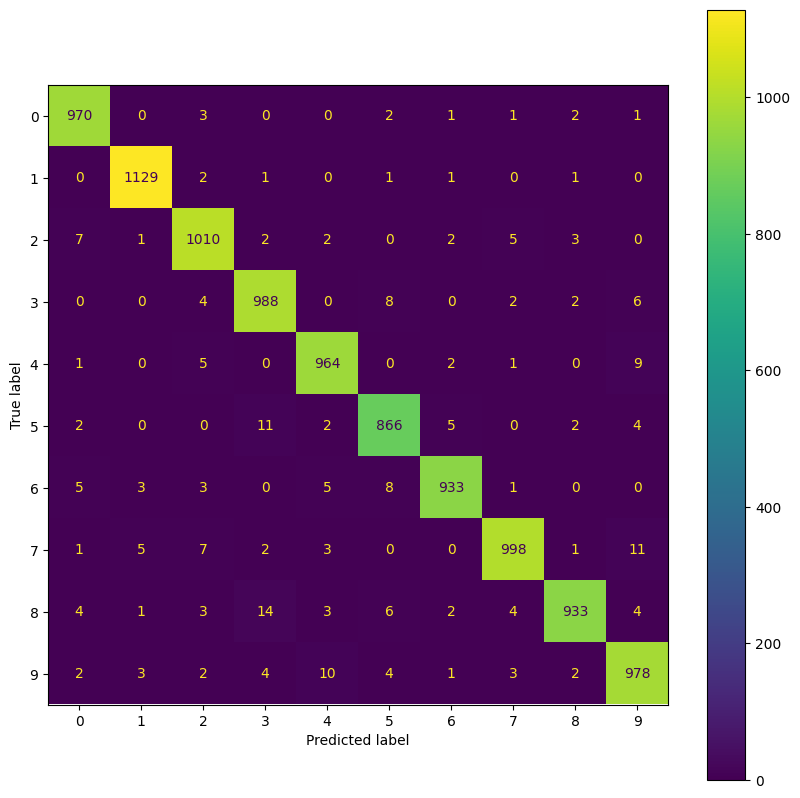

In [26]:
cm =confusion_matrix(y_test,test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names1)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## **Model 5 (changing the learning rate and batch size)**

Epoch number:  2 	Training cost: 2.2296014168319953
Epoch number:  4 	Training cost: 1.9949871955753735
Epoch number:  6 	Training cost: 1.755276968717479
Epoch number:  8 	Training cost: 1.5097426067951836
Epoch number:  10 	Training cost: 1.2846065814495045
Epoch number:  12 	Training cost: 1.0967053208202076
Epoch number:  14 	Training cost: 0.9488525622095012
Epoch number:  16 	Training cost: 0.8354164929133495
Epoch number:  18 	Training cost: 0.7487251982033644
Epoch number:  20 	Training cost: 0.6817861513359287
Epoch number:  22 	Training cost: 0.6292181304821639
Epoch number:  24 	Training cost: 0.5871000193739017
Epoch number:  26 	Training cost: 0.5526809801984588
Epoch number:  28 	Training cost: 0.5240502388238109
Epoch number:  30 	Training cost: 0.49988684165566855
Epoch number:  32 	Training cost: 0.47920303514823237
Epoch number:  34 	Training cost: 0.46128371383814415
Epoch number:  36 	Training cost: 0.4456192937746569
Epoch number:  38 	Training cost: 0.431802601807

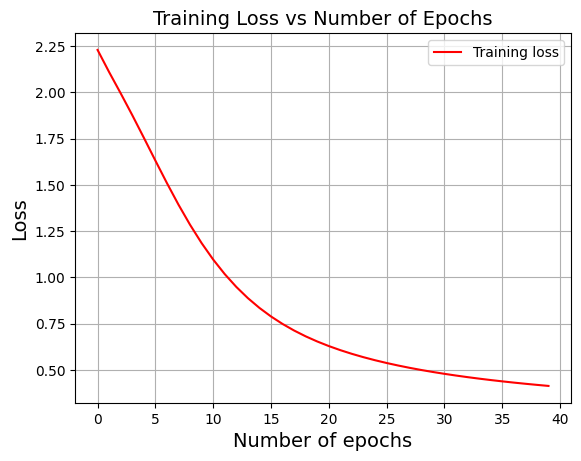

In [27]:
#model 5, number of neurons and lr change
LEARNING_RATE = 0.001 #
ACTIVATION = "relu"
INITIALIZER = "glorot"
OPTIMIZER = "sgd"
BATCH_SIZE = 512 #
EPOCHS = 40
L2_lambda = 0
NUM_NEURONS = [500,250,100]
NUM_HIDDEN = 3
LOSS = 'crossentropy'

learned_parameters, epoch_cost = best_fit(X_train, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

In [28]:
train_predictions, test_predictions = evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)


Training accuracy = 89.058 %
Test accuracy = 89.46 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.96      0.97      0.96      1135
           2       0.89      0.85      0.87      1032
           3       0.88      0.89      0.88      1010
           4       0.87      0.91      0.89       982
           5       0.87      0.82      0.85       892
           6       0.90      0.93      0.92       958
           7       0.90      0.88      0.89      1028
           8       0.86      0.86      0.86       974
           9       0.87      0.86      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



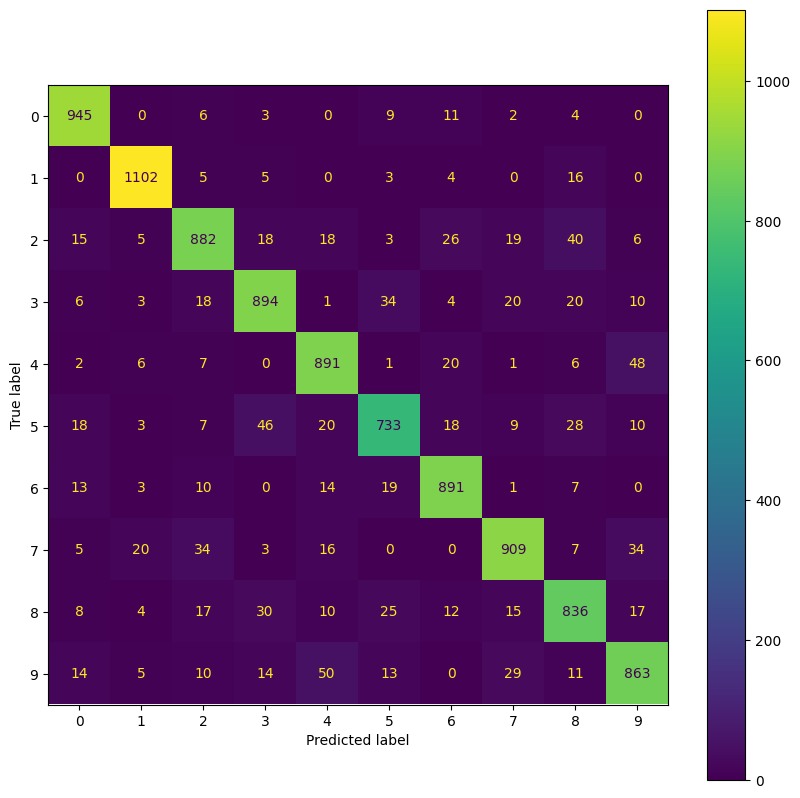

In [29]:
cm =confusion_matrix(y_test,test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names1)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## **Model 6 (intoducting the l2 regularization ,0.005)**

Epoch number:  2 	Training cost: 0.3139530147803353
Epoch number:  4 	Training cost: 0.19514276430644178
Epoch number:  6 	Training cost: 0.1497835374968194
Epoch number:  8 	Training cost: 0.12197124782237352
Epoch number:  10 	Training cost: 0.10197015611156234
Epoch number:  12 	Training cost: 0.08679643194390378
Epoch number:  14 	Training cost: 0.0746395203875427
Epoch number:  16 	Training cost: 0.0648614435114456
Epoch number:  18 	Training cost: 0.056755872525904257
Epoch number:  20 	Training cost: 0.05009391544998008
Epoch number:  22 	Training cost: 0.04435735715339846
Epoch number:  24 	Training cost: 0.039455021108526694
Epoch number:  26 	Training cost: 0.0351490620875554
Epoch number:  28 	Training cost: 0.031395449977614225
Epoch number:  30 	Training cost: 0.027995448997095388
Epoch number:  32 	Training cost: 0.025030713132648638
Epoch number:  34 	Training cost: 0.022405754216544067
Epoch number:  36 	Training cost: 0.020131184798810927
Epoch number:  38 	Training co

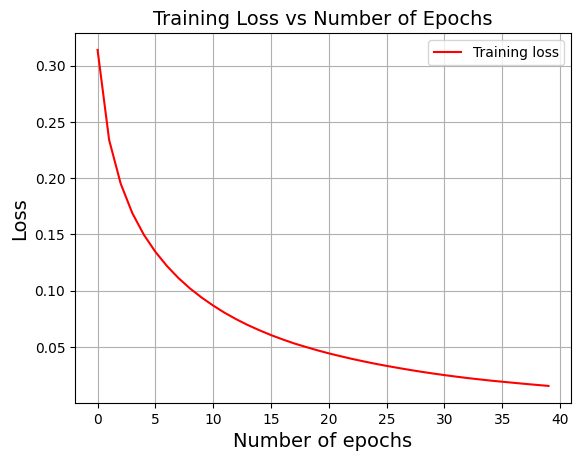

In [30]:
#model 6, number of neurons and lr change
LEARNING_RATE = 0.01 #
ACTIVATION = "relu"
INITIALIZER = "glorot"
OPTIMIZER = "sgd"
BATCH_SIZE = 64
EPOCHS = 40
L2_lambda = 0.005
NUM_NEURONS = [500,250,100]
NUM_HIDDEN = 3
LOSS = 'crossentropy'

learned_parameters, epoch_cost = best_fit(X_train, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

In [31]:
train_predictions, test_predictions = evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 99.757 %
Test accuracy = 97.72 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.99      0.96      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



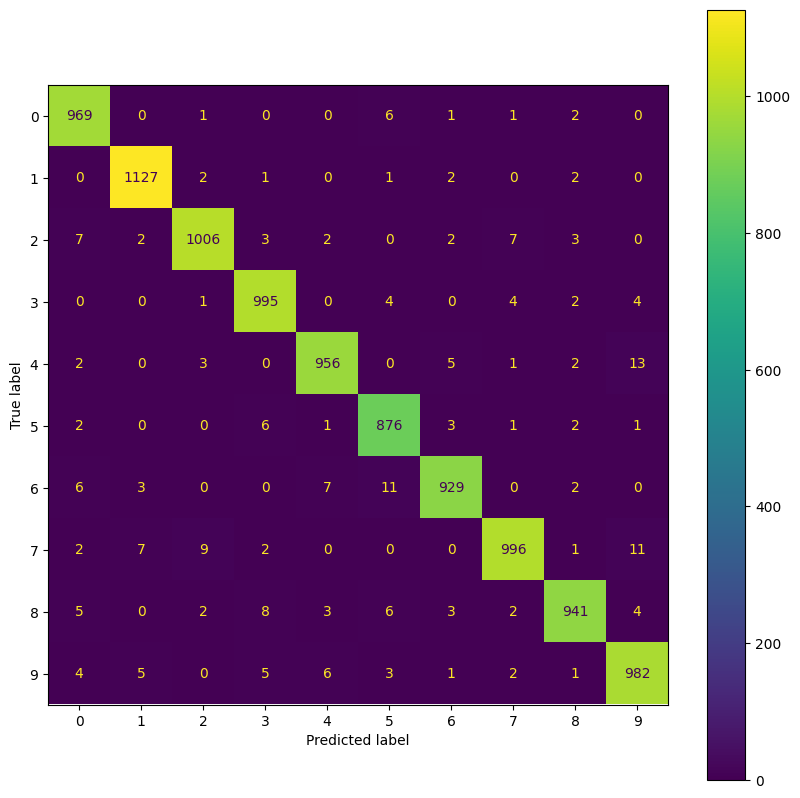

In [42]:
cm =confusion_matrix(y_test,test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names1)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## Model 7 (with l2 regularization value as 0.1)

Epoch number:  2 	Training cost: 0.3198155852792174
Epoch number:  4 	Training cost: 0.20469797695284783
Epoch number:  6 	Training cost: 0.16220305834188456
Epoch number:  8 	Training cost: 0.1368956927699782
Epoch number:  10 	Training cost: 0.11922892019890459
Epoch number:  12 	Training cost: 0.10588963029505871
Epoch number:  14 	Training cost: 0.09532552077140685
Epoch number:  16 	Training cost: 0.08690960512460305
Epoch number:  18 	Training cost: 0.0800507982978699
Epoch number:  20 	Training cost: 0.07423391501220807
Epoch number:  22 	Training cost: 0.0693784630983387
Epoch number:  24 	Training cost: 0.06520081908346519
Epoch number:  26 	Training cost: 0.06164080689745823
Epoch number:  28 	Training cost: 0.05853748249202783
Epoch number:  30 	Training cost: 0.055773938182042
Epoch number:  32 	Training cost: 0.0533717570685593
Epoch number:  34 	Training cost: 0.05126110639234398
Epoch number:  36 	Training cost: 0.04938937363983895
Epoch number:  38 	Training cost: 0.047

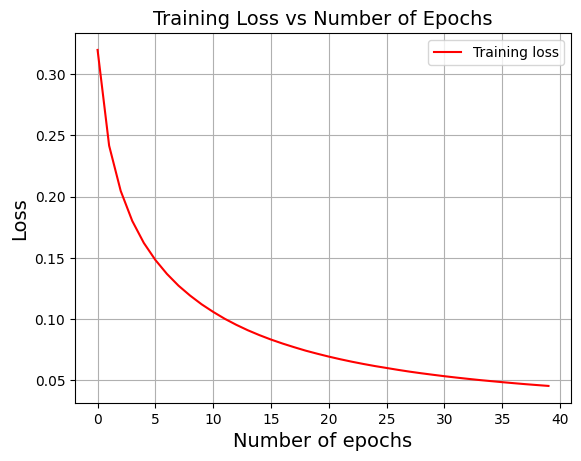

In [43]:
LEARNING_RATE = 0.01 #
ACTIVATION = "relu"
INITIALIZER = "glorot"
OPTIMIZER = "sgd"
BATCH_SIZE = 64
EPOCHS = 40
L2_lambda = 0.1
NUM_NEURONS = [500,250,100]
NUM_HIDDEN = 3
LOSS = 'crossentropy'

learned_parameters, epoch_cost = best_fit(X_train, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

In [34]:
train_predictions, test_predictions = evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 99.013 %
Test accuracy = 97.77 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.98      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



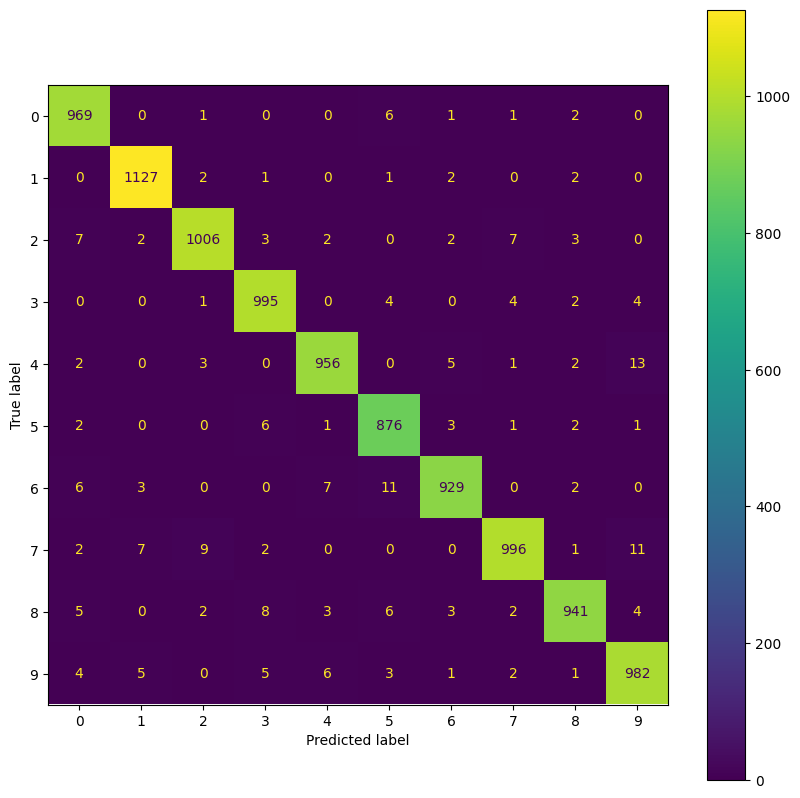

In [35]:
cm =confusion_matrix(y_test,test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names1)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## **Implementation using Pytorch**

In [36]:
from torchvision.transforms import Lambda, ToTensor, Compose
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

transform = transforms.Compose([transforms.ToTensor()])#,
                              #transforms.Normalize((0.5,), (0.5,)),
                              #])
train_loader =DataLoader(datasets.MNIST(root='data',train=True, download = True,transform=transform), batch_size= 64, shuffle =True)
test_loader = DataLoader(datasets.MNIST(root='data', train= False, download = True, transform=transform), batch_size =64, shuffle = True)

In [37]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500,250)
        self.fc3 = nn.Linear(250,100)
        self.fc4 = nn.Linear(100, 10)


    def forward(self, x):
        # Adding hidden layers with Relu activation function
        x=x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [38]:
model= MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch number:  2 	Training cost: 0.17974577706728154
Epoch number:  4 	Training cost: 0.13092143164000916
Epoch number:  6 	Training cost: 0.11504391677303315
Epoch number:  8 	Training cost: 0.11061986934007413
Epoch number:  10 	Training cost: 0.09680726342751503
Epoch number:  12 	Training cost: 0.08179766004004685
Epoch number:  14 	Training cost: 0.0916587834217508


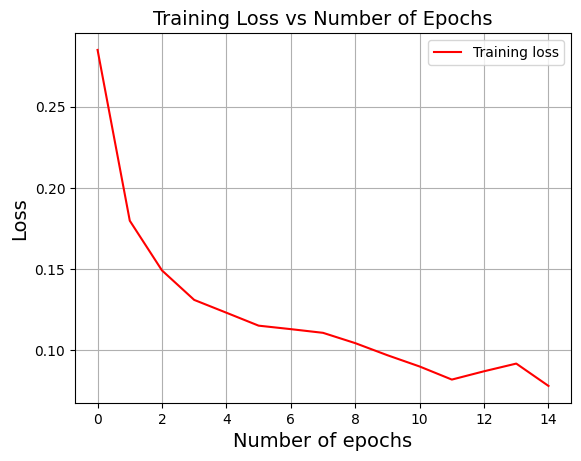

In [39]:
num_epoch = 15
train_cost =[]

for i in range(1, num_epoch+1):
    train_loss=0
    model.train()
    for x,y in train_loader:
        optimizer.zero_grad()
        y_pred = model.forward(x)
        loss =criterion(y_pred,y)
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()#.append(loss.item())

#     cost = np.mean(train_loss)
    train_loss = train_loss/len(train_loader)
    train_cost.append(train_loss)

    if i%2==0:
        print("Epoch number: ", i, "\tTraining cost:", train_loss)

plt.plot(list(range(len(train_cost))), train_cost, 'r', label="Training loss")
plt.title("Training Loss vs Number of Epochs", size=14)
plt.xlabel("Number of epochs", size=14)
plt.ylabel("Loss", size=14)
plt.grid()
plt.legend()
plt.show()


In [40]:
test_loss =0
total =0
correct =0
loss =0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for x,y in test_loader:
        y_pred= model(x)
        loss = criterion(y_pred, y)
        test_loss +=loss.item()
        _, predicted = torch.max(y_pred.data,1)
        total +=y.size(0)
        correct +=(predicted==y).sum().item()
        true_labels.extend(y.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
avg_validation_loss = test_loss / len(test_loader)
# loss.append(avg_validation_loss)
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 97.52%


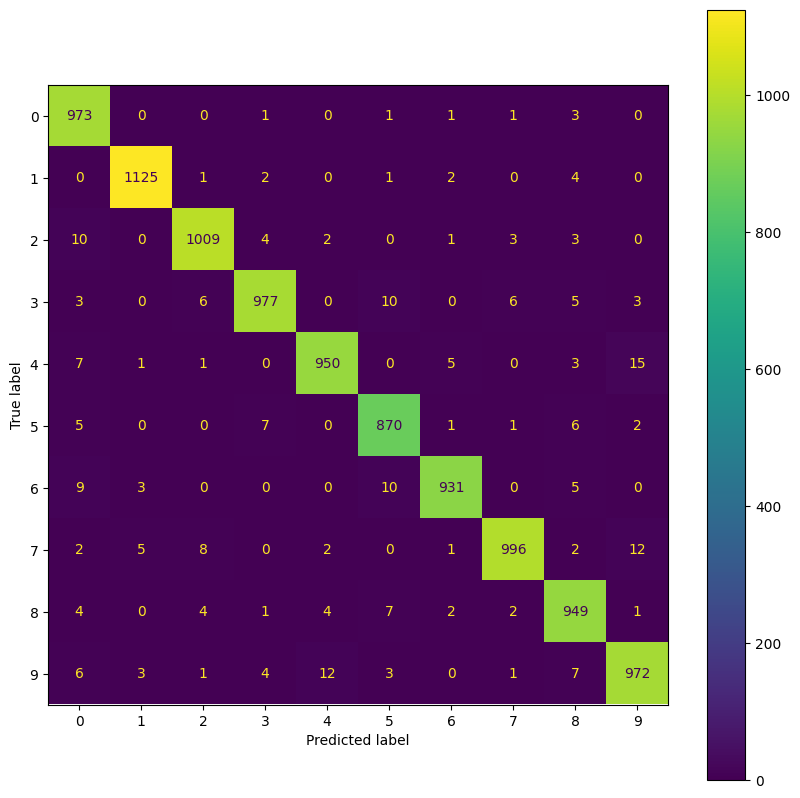

In [41]:
class_names1 = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']
cm =confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names1)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()


## The accuracies of pytorch implementation(96.90) and implementation from scratch(97.12) are almost same.
